In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Effects of scaling on global feature importance in forecasting machine learning models

## Feature scaling
We can use the two types of feature scaling methods to scale the features:
- Linear scaling like min-max, standard scaling, and robust scaling.
- Non-linear scaling like log, power, root, exponential, box-cox, yeo-johnson, and quantile scaling.

These are the formulas for the different types of scaling:
- Linear scaling: $x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$
- Standard scaling: $x' = \frac{x - \text{mean}(x)}{\text{std}(x)}$
- Robust scaling: $x' = \frac{x - \text{median}(x)}{\text{IQR}(x)}$
- Log scaling: $x' = \log(x)$
- Power scaling: $x' = x^p$
- Root scaling: $x' = \sqrt{x}$
- Exponential scaling: $x' = e^x$
- Box-Cox scaling: $x' = \frac{x^p - 1}{p}$
- Yeo-Johnson scaling: $x' = \begin{cases} \left( x + 1 \right)^p & \text{if } x \geq 0 \\ -\left( -x + 1 \right)^p & \text{if } x < 0 \end{cases}$
- Quantile scaling: $x' = \text{CDF}^{-1}(x)$

where $x$ is the original feature, $x'$ is the scaled feature, $\text{min}(x)$ is the minimum value of $x$, $\text{max}(x)$ is the maximum value of $x$, $\text{mean}(x)$ is the mean value of $x$, $\text{std}(x)$ is the standard deviation of $x$, $\text{median}(x)$ is the median value of $x$, $\text{IQR}(x)$ is the interquartile range of $x$, $p$ is the power parameter, and $\text{CDF}^{-1}(x)$ is the inverse cumulative distribution function of $x$.


### Goal
Evaluate the effects of scaling on global feature importance in forecasting machine learning models.


## Datasets:
- Linear dataset: [Ref](data\linear_dep_time_series.csv)
- Non-linear dataset: [Ref](data\nonlinear_time_series.csv)

,date,s_1,s_2,s_3,holiday,weather
0,2023-01-01,50.000000,150.000000,300.000000,0,31.852103
1,2023-01-02,100.000000,200.000000,350.000000,1,13.299608
2,2023-01-03,100.609331,195.258758,368.269784,0,29.497161
3,2023-01-04,99.437613,165.805578,351.979250,0,16.390125
4,2023-01-05,98.066940,176.120203,369.788392,0,16.449677


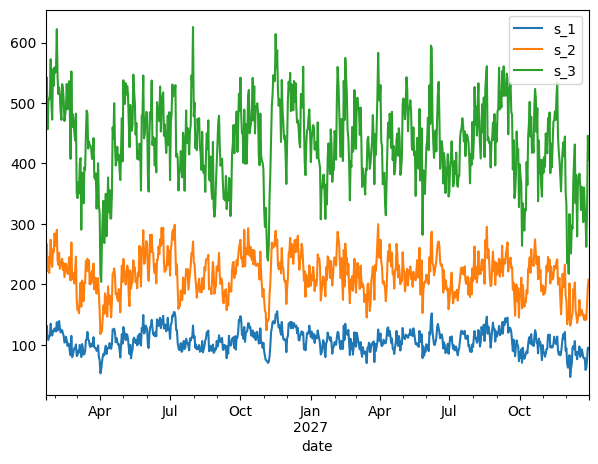

In [4]:
import pandas as pd

df_lin = pd.read_csv("data/linear_dep_time_series.csv")
series = ["s_1", "s_2", "s_3"]
df_lin["date"] = pd.to_datetime(df_lin["date"])
df_lin.set_index("date")[series][-710:].plot(figsize=(7, 5))
display(df_lin.head())




## Preprocessing of datasets

Preprocesing steps:
- Split the series from the exogenous features.
- Transform to long format 
- Split the data into training and test sets.


C:\Users\Matty\AppData\Local\Temp\ipykernel_38772\991658549.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_exog = pd.concat([df_exog, df_exog_brand])


Dataset dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=1825)
Train dates      : (Timestamp('2023-01-01 00:00:00'), Timestamp('2026-12-31 00:00:00'))  (n=1461)
Test dates      : (Timestamp('2027-01-01 00:00:00'), Timestamp('2027-12-30 00:00:00'))  (n=364)


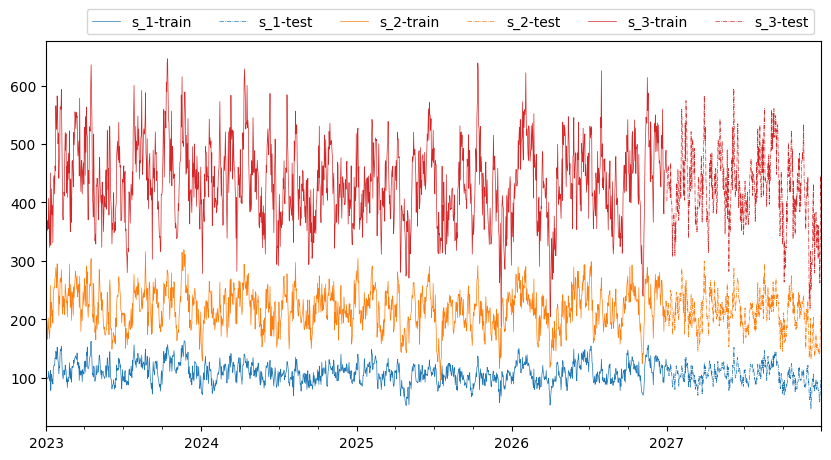

In [5]:
## Prepare linear combined data
from tsxp.dataset import ForecasterMsDataset, DatasetMapping
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection  import TimeSeriesFold


df_lin["date"] = pd.to_datetime(df_lin["date"])

# melt the series and prepare for the model
df_demand = df_lin.melt(
    id_vars=["date"], value_vars=series, var_name="series_id", value_name="value"
)

# create exog dataframe for holiday and	weather
df_exog_temp = df_lin[["date", "holiday", "weather"]].drop_duplicates()


#replicate the exog data for each series and set the series_id
df_exog = pd.DataFrame(columns=df_exog_temp.columns)
#df_exog["holiday"] = df_exog["holiday"].astype(bool)
df_exog["holiday"] = df_exog["holiday"].astype(int)


df_exog["series_id"] = ""
for brand in series:
    df_exog_brand = df_exog_temp.copy()
    df_exog_brand["series_id"] = brand
    df_exog = pd.concat([df_exog, df_exog_brand])


mapping = DatasetMapping(
    freq="D",
    index="date",
    series_id="series_id",
    series_value="value",
)

# define split date
split_date = "2026-12-31"


lin_dataset = ForecasterMsDataset(df_demand, df_exog, mapping, split_time=split_date)
lin_dataset.show_sizes()
lin_dataset.plot_series()

## Train and explain the models

Train the models:
- LigthGBM model
- Random Forest model ??

Importance metrics:
- SHAP values - Tree explainer, Kernel explainer
- Permutation feature importance - Mean average error (MAE) 

With and without scaling the features.

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.507296
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 0.500902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training 

'Scaled : (               0\nMAE    15.058390\nMSE   444.436642\nR2      0.977546\nMAPE    0.063590,            MAE          MSE        R2      MAPE\ns_1   6.799446    71.143394  0.737403  0.067797\ns_2  12.593363   234.775498  0.764469  0.061670\ns_3  25.782362  1027.391035  0.756407  0.061303)'

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 265.407917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start training from score 252.400897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 1083, number of used features: 7
[LightGBM] [Info] Start train

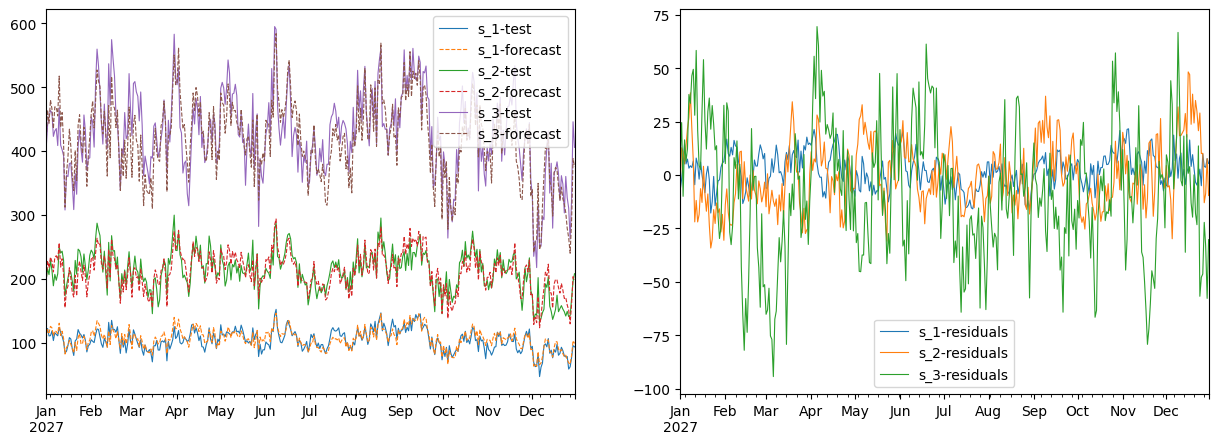

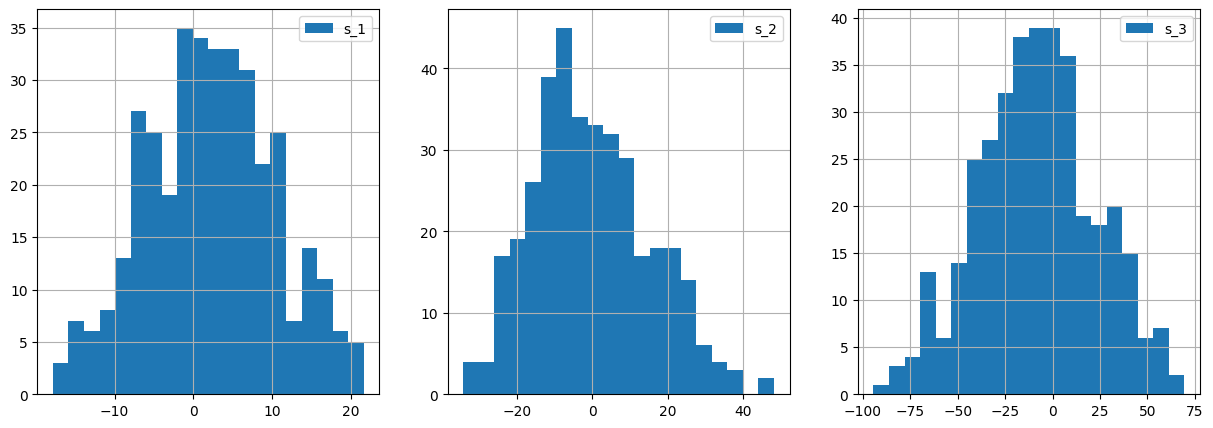

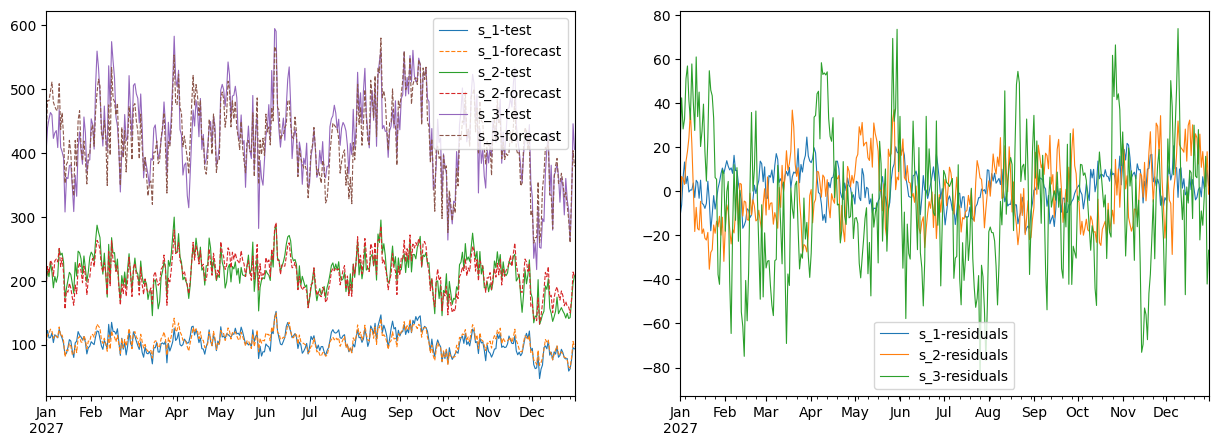

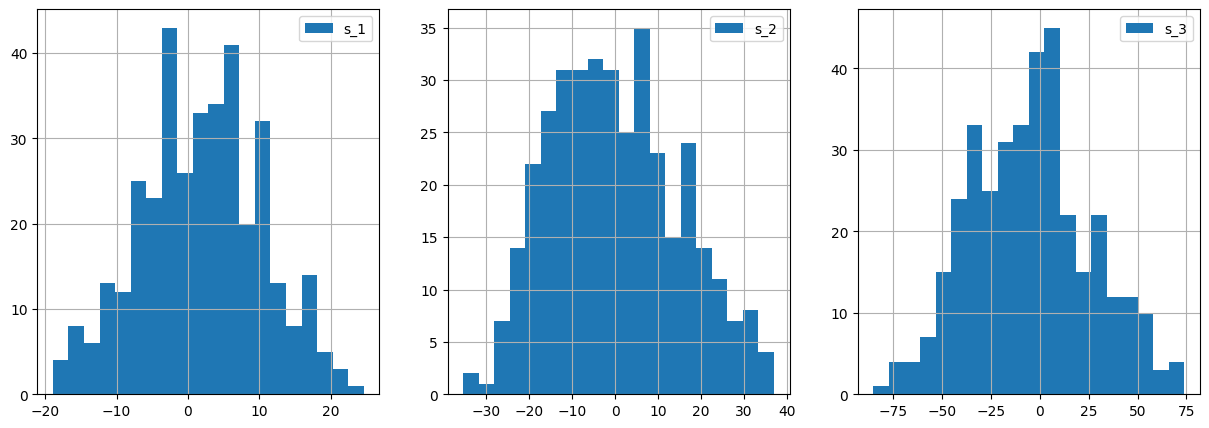

In [14]:
# forecast linear
# 
from tsxp.forecaster import ForecasterMsExog
from lightgbm import LGBMRegressor


def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }


regressor:LGBMRegressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_scaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
display("Scaled : "+ str(forecaster_scaled.calculate_test_performance_metrics()))
forecaster_scaled.plot_forecast()


r1regressor = LGBMRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

forecaster_nonscaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=r1regressor,
    scale=None
    # search_space=search_space,
)
t2 = forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  

forecaster_nonscaled.plot_forecast()





In [15]:
display("Scaled : ")
display(forecaster_scaled.calculate_test_performance_metrics())
display("Not scaled:")
display(forecaster_nonscaled.calculate_test_performance_metrics())

'Scaled : '

(               0
 MAE    15.058390
 MSE   444.436642
 R2      0.977546
 MAPE    0.063590,
            MAE          MSE        R2      MAPE
 s_1   6.799446    71.143394  0.737403  0.067797
 s_2  12.593363   234.775498  0.764469  0.061670
 s_3  25.782362  1027.391035  0.756407  0.061303)

'Not scaled:'

(               0
 MAE    14.729939
 MSE   415.986182
 R2      0.978984
 MAPE    0.063413,
            MAE         MSE        R2      MAPE
 s_1   7.081032   75.331302  0.721945  0.070449
 s_2  12.475931  226.210606  0.773061  0.060863
 s_3  24.632853  946.416637  0.775606  0.058925)

In [ ]:
from tsxp.forecaster import ForecasterMsExog

from sklearn.ensemble import RandomForestRegressor

def search_space(trial):
    return {
        "lags": trial.suggest_categorical("lags", [4]), #, [1, 2, 4, 5]]),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1200),
        # "max_depth": trial.suggest_int("max_depth", 2, 15),
        # "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.01),
        # "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 20),
        # "min_child_samples": trial.suggest_int("min_child_samples", 2, 20),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 10),
    }

regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

rf_forecaster_scaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=scaler
    # search_space=search_space,
)
t1 = rf_forecaster_scaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
rf_forecaster_scaled.plot_forecast()
display(rf_forecaster_scaled.calculate_test_performance_metrics())
######### Not scaled
regressor = RandomForestRegressor()

scaler = MinMaxScaler()

cv = TimeSeriesFold(initial_train_size=365, steps=365, refit=True)

rf_forecaster_nonscaled = ForecasterMsExog( 
    data = lin_dataset,
    regressor=regressor,
    scale=None
    # search_space=search_space,
)
t2 = rf_forecaster_nonscaled.bayesian_search(search_space=search_space,cv=cv, n_trials=10)  
rf_forecaster_nonscaled.plot_forecast()
display(rf_forecaster_nonscaled.calculate_test_performance_metrics())

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'n_estimators': 531}
  Backtesting metric: 17.455252523313405
  Levels: ['s_1', 's_2', 's_3']



(               0
 MAE    14.349349
 MSE   405.858004
 R2      0.979495
 MAPE    0.063504,
            MAE         MSE        R2      MAPE
 s_1   7.316967   81.701054  0.698433  0.074633
 s_2  11.876640  212.908095  0.786407  0.057902
 s_3  23.854440  922.964862  0.781166  0.057976)

  0%|          | 0/10 [00:00<?, ?it/s]

### Model training summary

On test set the models achieve 0.97 ~R^2 score which makes sense given that the generated data has added noise.

## Feature importance calculation

Metrics calculated:
- Tree SHAP values: train and test 
- Kernel SHAP values: train and test
- PFI: ---
- Tree gain: both for LightGBM and Random Forest
- Tree split: for LightGBM

Features are also ranked and relative importance is also calculated. 

Shap is calculated for each model and dataset.

 99%|===================| 4325/4371 [00:43<00:00]        

,PFI_MSE,PFI_MSE_TEST,PFI_R2,PFI_R2_TEST,TREE_SHAP_TEST,TREE_SHAP_TRAIN,TREE_PATH_SHAP,TREE_GAIN,TREE_SPLIT
lag_1,0.018085,1.484342e-02,0.766832,0.716394,0.069026,0.075007,0.078089,295.675272,1982
weather,0.016094,1.635455e-02,0.682413,0.789326,0.073570,0.071418,0.071051,185.853593,2012
lag_2,0.002538,1.381711e-03,0.107621,0.066686,0.021744,0.023848,0.022270,32.652512,1971
lag_4,0.000627,-2.394343e-06,0.026603,-0.000116,0.004583,0.005231,0.004853,6.326154,2065
lag_3,0.000619,2.603537e-07,0.026258,0.000013,0.005009,0.005676,0.005571,6.081030,1886
holiday,0.000284,1.909543e-04,0.012049,0.009216,0.009161,0.009233,0.008873,2.589796,264
_level_skforecast,0.000200,4.122578e-06,0.008467,0.000199,0.002787,0.002988,0.002966,1.071461,290


Rank                                                 \
                  PFI_MSE PFI_MSE_TEST PFI_R2 PFI_R2_TEST TREE_SHAP_TEST   
lag_1                   1            2      1           2              2   
weather                 2            1      2           1              1   
lag_2                   3            3      3           3              3   
lag_4                   4            7      4           7              6   
lag_3                   5            6      5           6              5   
holiday                 6            4      6           4              4   
_level_skforecast       7            5      7           5              7   

                                                                       
                  TREE_SHAP_TRAIN TREE_PATH_SHAP TREE_GAIN TREE_SPLIT  
lag_1                           1              1         1          3  
weather                         2              2         2          2  
lag_2                           3              3         3          4  
lag_4                           6              6         4          1  
lag_3                           5              5         5          5  
holiday                         4              4         6          7  
_level_skforecast               7              7         7          6

Perc                                      \
                     PFI_MSE PFI_MSE_TEST     PFI_R2 PFI_R2_TEST   
lag_1              47.037873    45.292131  47.037873   45.292131   
weather            41.859593    49.903083  41.859593   49.903083   
lag_2               6.601536     4.216054   6.601536    4.216054   
lag_4               1.631846    -0.007306   1.631846   -0.007306   
lag_3               1.610705     0.000794   1.610705    0.000794   
holiday             0.739083     0.582664   0.739083    0.582664   
_level_skforecast   0.519364     0.012579   0.519364    0.012579   

                                                                            \
                  TREE_SHAP_TEST TREE_SHAP_TRAIN TREE_PATH_SHAP  TREE_GAIN   
lag_1                  37.134639       38.783117      40.319856  55.761504   
weather                39.579413       36.927647      36.685986  35.050195   
lag_2                  11.698083       12.330935      11.498906   6.157949   
lag_4                   2.465398        2.704730       2.505798   1.193052   
lag_3                   2.694545        2.934872       2.876513   1.146824   
holiday                 4.928450        4.773885       4.581488   0.488410   
_level_skforecast       1.499472        1.544814       1.531454   0.202067   

                              
                  TREE_SPLIT  
lag_1              18.930277  
weather            19.216810  
lag_2              18.825215  
lag_4              19.723018  
lag_3              18.013372  
holiday             2.521490  
_level_skforecast   2.769819

 99%|===================| 4312/4371 [00:45<00:00]        

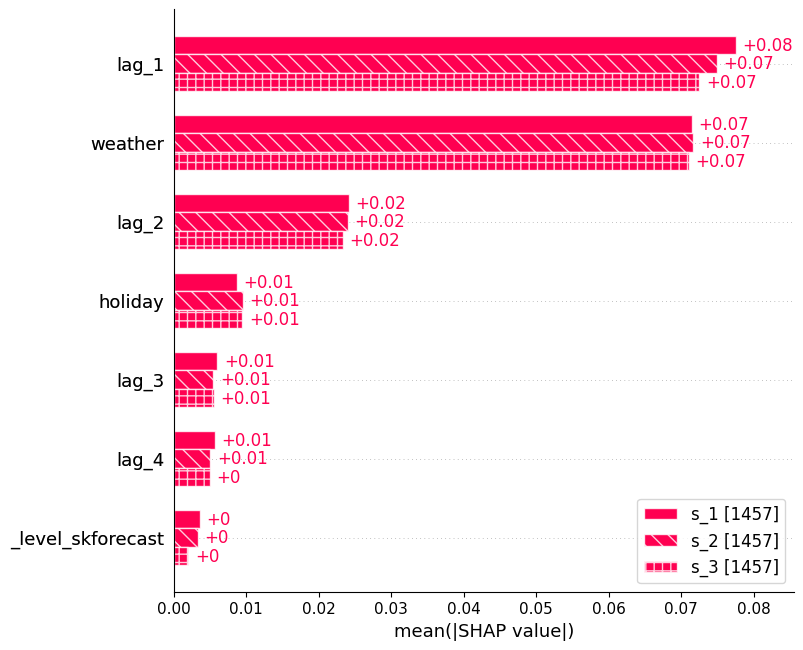

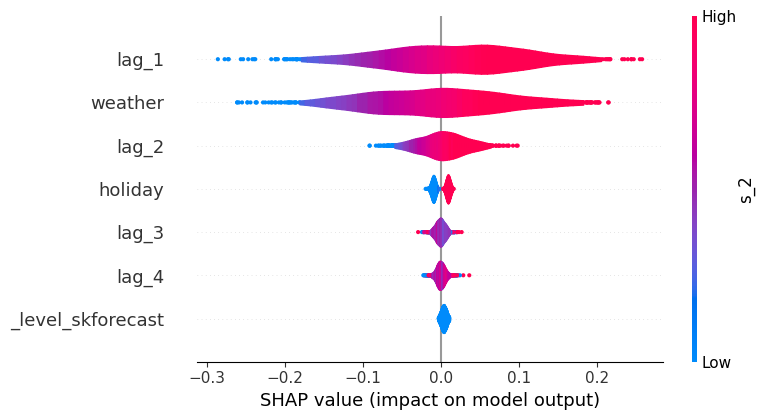

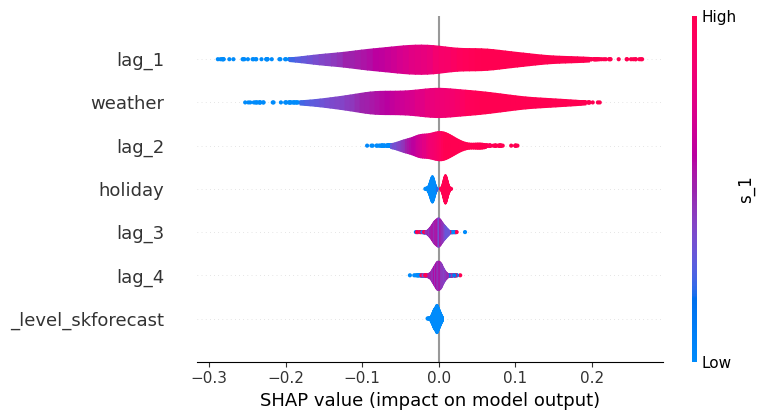

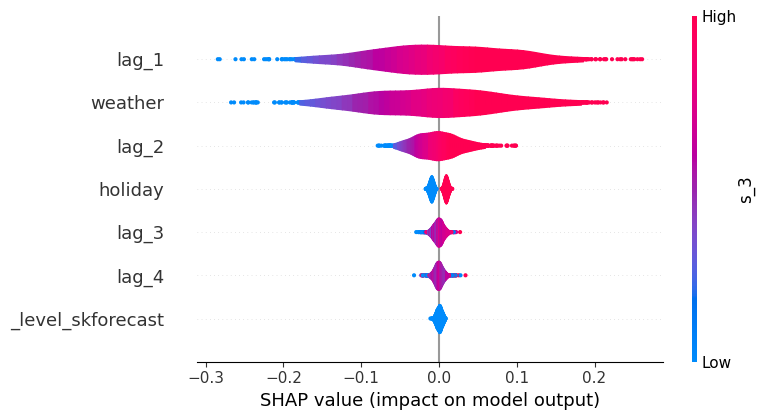

<Figure size 640x480 with 0 Axes>

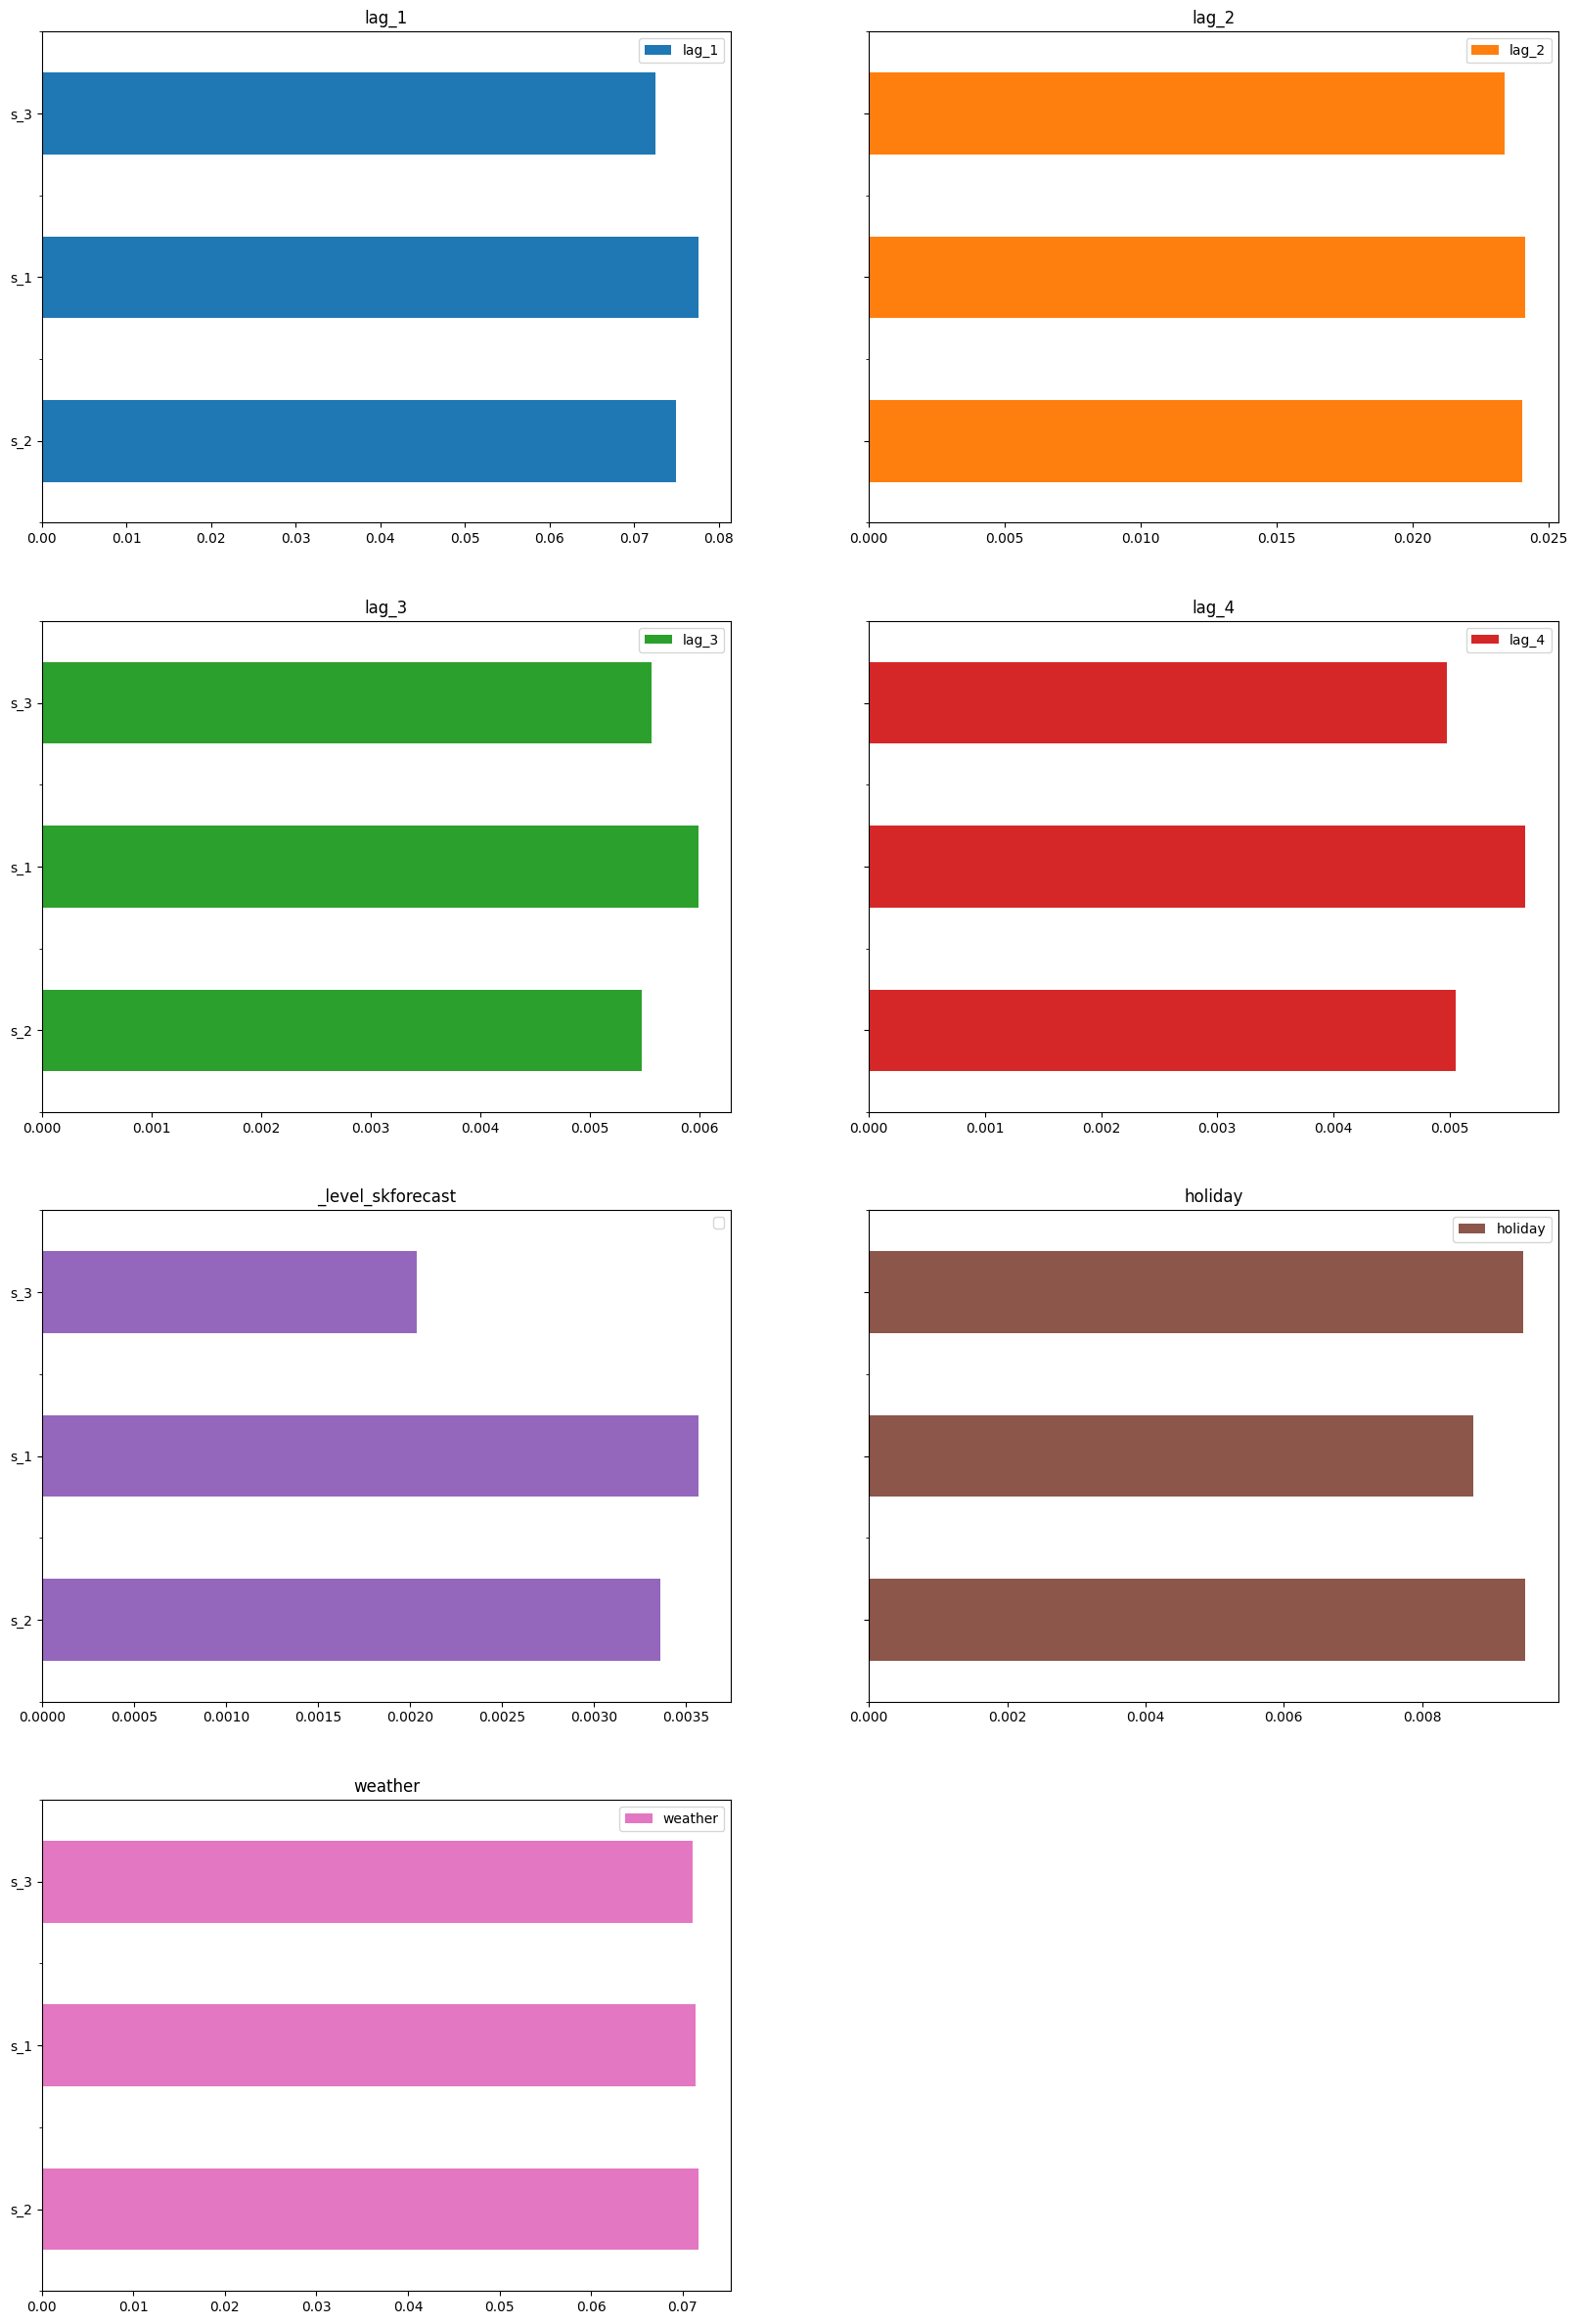

In [ ]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
from IPython.display import display, HTML

forecasters = {
    "lgbm_scaled": forecaster_scaled,
    "lgbm_nonscaled": forecaster_nonscaled,
    # "rf_forecaster_scaled": rf_forecaster_scaled,
    # "rf_forecaster_nonscaled": rf_forecaster_nonscaled,
}

explainers = {}

for name, forecaster in forecasters.items():
    display(HTML(data="<h1>Calculating:"+name+"<h1/>"))
    fi_explainer = ForecasterMsExogFeatureImportance(forecaster)
    explainers[name] = fi_explainer
    display(HTML(data="<h1> Importances: "+name+"<h1/>"))
    # explainer.calculate_feature_importance()
    display(fi_explainer.feature_importance)
    display(fi_explainer.feature_rank)
    display(fi_explainer.relative_feature_importance)
    fi_explainer.plot_importance_for_series()
# fi_explainer = ForecasterMsExogFeatureImportance(forecaster_scaled)


In [ ]:
from tsxp.explainers import ForecasterMsExogFeatureImportance
from IPython.display import display, HTML

forecasters = {
    # "lgbm_scaled": forecaster_scaled,
    # "lgbm_nonscaled": forecaster_nonscaled,
    "rf_forecaster_scaled": rf_forecaster_scaled,
    "rf_forecaster_nonscaled": rf_forecaster_nonscaled,
}
 

for name, forecaster in forecasters.items():
    display(HTML(data="<h1>Calculating:"+name+"<h1/>"))
    fi_explainer = ForecasterMsExogFeatureImportance(forecaster)
    explainers[name] = fi_explainer
    display(HTML(data="<h1> Importances: "+name+"<h1/>"))
    # explainer.calculate_feature_importance()
    display(fi_explainer.feature_importance)
    display(fi_explainer.feature_rank)
    display(fi_explainer.relative_feature_importance)
    fi_explainer.plot_importance_for_series()
# fi_explainer = ForecasterMsExogFeatureImportance(forecaster_scaled)
